# Comparisons using the BatchStudy class

In this notebook, we will be going through the `BatchStudy` class and will be discussing how different models, experiments, chemistries, etc. can be compared with each other using the same.

## Comparing models
We start by creating a simple script to compare `SPM`, `SPMe` and `DFN` model with the default parameters.

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm

# loading up 3 models to compare
dfn = pybamm.lithium_ion.DFN()
spm = pybamm.lithium_ion.SPM()
spme = pybamm.lithium_ion.SPMe()

Note: you may need to restart the kernel to use updated packages.


The `BatchStudy` class requires a dictionary of models, and all the default values for a given model are used if no additional parameter is passed in.

In [2]:
models = {
    "dfn": dfn,
    "spm": spm,
    "spme": spme,
}

# creating a BatchStudy object
batch_study = pybamm.BatchStudy(models=models)

# solving and plotting the comparison
batch_study.solve(t_eval=[0, 3600])
batch_study.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

`BatchStudy` by default requires equal number of items in all the dictionaries passed, which can be changed by setting the value of `permutations` to `True`. When set `True`, a cartesian product of all the available items is taken.

For example, here we pass 3 models but only 1 parameter value, hence it is necessary to set `permutations` to `True`. Here, the given parameter value is used for all the provided models.

In [3]:
# passing parameter_values as a dictionary
parameter_values = {"Chen2020": pybamm.ParameterValues("Chen2020")}

# creating a BatchStudy object and solving the simulation
batch_study = pybamm.BatchStudy(models=models, parameter_values=parameter_values, permutations=True)
batch_study.solve(t_eval=[0, 3600])
batch_study.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=3567.8551657209678, step=35.67855165720968),…

## Comparing parameters

`BatchStudy` can also be used to compare different things (like affect of changing a parameter's value) on a single model.

In the following cell, we compare different values of `"Curent function [A]"` using the `Single Paritcle Model with electrolyte`.


In [4]:
model = {"spme": spme}

# populating a dictionary with 3 same parameter values
parameter_values = {
    "Chen2020_1": pybamm.ParameterValues("Chen2020"),
    "Chen2020_2": pybamm.ParameterValues("Chen2020"),
    "Chen2020_3": pybamm.ParameterValues("Chen2020"),
}

# different values for "Current function [A]"
current_values = [4.5, 4.75, 5]

# changing the value of "Current function [A]" in all the parameter values present in the 
# parameter_values dictionary
for k, v, current_value in zip(parameter_values.keys(), parameter_values.values(), current_values):
    v["Current function [A]"] = current_value 

# creating a BatchStudy object with permutations set to True to create a cartesian product
batch_study = pybamm.BatchStudy(models=model, parameter_values=parameter_values, permutations=True)
batch_study.solve(t_eval=[0, 3600])

# generating the required labels and plotting
labels = [f"Current function [A]: {current}" for current in current_values]
batch_study.plot(labels=labels)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

`BatchStudy` also includes a `create_gif` method which can be used to create a GIF of the simulation.

In [5]:
# using less number of images in the example
# for a smoother GIF use more images
batch_study.create_gif(number_of_images=5, duration=0.2)

Displaying the GIF using markdown-

![plot](https://user-images.githubusercontent.com/74055102/142717896-8152e816-71b1-47a7-b557-57cf6dbfc839.gif)

## Using experiments

Experiments can also be specified for comparisons, and they are also passed as a dictionary (a dictionary of `pybamm.Experiment`) in the `BatchStudy` class.

In the next cell, we compare a single experiment, with a single model, but with a varied parameter value.


In [6]:
pybamm.set_logging_level("NOTICE")

# using the cccv experiment with 10 cycles
cccv = pybamm.Experiment(
    [
        ("Discharge at C/10 for 10 hours or until 3.3 V",
        "Rest for 1 hour",
        "Charge at 1 A until 4.1 V",
        "Hold at 4.1 V until 50 mA",
        "Rest for 1 hour")
    ]
    * 10,
)

# creating the experiment dict
experiment = {
    "cccv": cccv
}

# populating a dictionary with 3 same parameter values (Mohtat2020 chemistry)
parameter_values = {
    "Mohtat2020_1": pybamm.ParameterValues("Mohtat2020"),
    "Mohtat2020_2": pybamm.ParameterValues("Mohtat2020"),
    "Mohtat2020_3": pybamm.ParameterValues("Mohtat2020"),
}

# different values for the parameter "Inner SEI open-circuit potential [V]"
inner_sei_oc_v_values = [2.0e-4, 2.7e-4, 3.4e-4]

# updating the value of "Inner SEI open-circuit potential [V]" in all the dictionary items
for k, v, inner_sei_oc_v in zip(parameter_values.keys(), parameter_values.values(), inner_sei_oc_v_values):
    v.update(
        {
            "Inner SEI open-circuit potential [V]": inner_sei_oc_v
        },
    )

# creating a Single Particle Model with "electron-mitigation limited" SEI
model = {"spm": pybamm.lithium_ion.SPM({"SEI": "electron-migration limited"})}

# creating a BatchStudy object with the given experimen, model and parameter_values
batch_study = pybamm.BatchStudy(models=model, experiments=experiment, parameter_values=parameter_values, permutations=True)

#solving and plotting the result
batch_study.solve(initial_soc=1)

labels = [f"Inner SEI open-circuit potential [V]: {inner_sei_oc_v}" for inner_sei_oc_v in inner_sei_oc_v_values]
batch_study.plot(labels=labels)


2022-07-26 16:44:42.414 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/10 (35.637 ms elapsed) --------------------
2022-07-26 16:44:42.415 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 1/5: Discharge at C/10 for 10 hours or until 3.3 V
2022-07-26 16:44:42.565 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 2/5: Rest for 1 hour
2022-07-26 16:44:42.594 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 3/5: Charge at 1 A until 4.1 V
2022-07-26 16:44:42.684 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 4/5: Hold at 4.1 V until 50 mA
2022-07-26 16:44:42.726 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 5/5: Rest for 1 hour
2022-07-26 16:44:42.921 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/10 (542.652 ms elapsed) --------------------
2022-07-26 16:44:42.922 - [NOTICE] callbacks.on_step_start(182): Cycle 2/10, step 1/5: Discharge at C/10 for 10 hours or until 3.3 V
2022-07-26 16:44:43.047 - [NOTICE] callbacks.on_step_start(182): 

interactive(children=(FloatSlider(value=0.0, description='t', max=155.71556450330894, step=1.5571556450330895)…

The difference in the individual plots is not very well visible in the above slider plot, but we can access all the simulations created by `BatchStudy` (`batch_study.sims`) and pass it to `pybamm.plot_summary_variables` to plot the summary variables (more details on "summary variables" are available in the [`simulationg-long-experiments`](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/notebooks/simulating-long-experiments.ipynb) notebook).

## Comparing summary variables

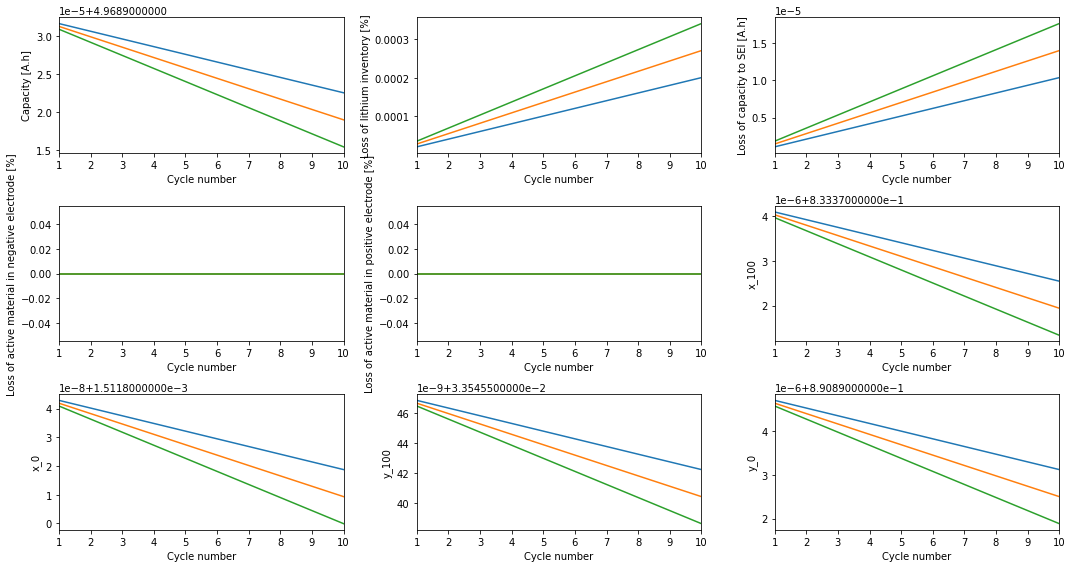

array([[<AxesSubplot:xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [7]:
pybamm.plot_summary_variables([sim.solution for sim in batch_study.sims])

Other than the above examples, the `BatchStudy` class can be used to compare a lot of different configurations, like models with different SEIs or a model with reversible and irreversible lithium plating, etc.

## References

The relevant papers for this notebook are:

In [8]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[3] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with